In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
import torch.nn.functional as F

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),     
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=16)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=16)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
import torch
import torch.nn as nn

from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import torch.nn.init as init


In [5]:
def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [6]:
device='cuda'

In [8]:
import torch.optim as optim
class ResNet(pl.LightningModule):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 16
        n_in=self.in_planes
        self.conv1 = nn.Conv2d(3, n_in, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(n_in)
        self.layer1 = self._make_layer(block, n_in, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, n_in*2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, n_in*4, num_blocks[2], stride=2)

        self.linear = nn.Linear(n_in*4, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred=self(x)
        loss = F.cross_entropy(y_pred, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred=self(x)
        preds = torch.argmax(y_pred,dim=1)
        loss = F.cross_entropy(y_pred, y)
        correct=torch.sum(preds==y)
        total=len(y)
        self.log('val_loss', loss,prog_bar=True)
        return correct,total

    def validation_epoch_end(self, val_step_outputs):
        correct=0
        total=0
        for i,j in val_step_outputs:
            correct+=i
            total+=j
        self.log('acc',correct/total,prog_bar=True)
    def configure_optimizers(self):
            optimizer = optim.SGD(self.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=1e-4)
            return {'optimizer':optimizer,
        'lr_sheduler' :optim.lr_scheduler.MultiStepLR(optimizer,[100,150],)
        }


In [25]:
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
def check(fu=lambda x,y:  (x,y),arg=None):
    model= ResNet(BasicBlock, [3,3,3])
    state_dict=torch.load('result_model.pt')
    model.load_state_dict(state_dict=state_dict)
    fu(model,arg)
    corr=[]
    predictions=[]
    for x,y in tqdm(testloader):
        y_pred=model(x)
        predictions.append(torch.argmax(y_pred,dim=1).numpy())
        corr.append(y.numpy())
    correct_labels=np.hstack(corr)
    pred_labels=np.hstack(predictions)
    return {'accuracy':(correct_labels==pred_labels).mean(), 'num_parameters':sum(p.numel() for p in model.parameters()),'k':arg}

Далее идут функции, обрабатывающие основной строительный блок conv1-bn1-conv2.  
В conv1 мы кластеризуем свертки и понижаем размер тензора весов до k. Получается свертка с меньшим числом каналов.  
В bn1 мы передаем маску(какие свертки относились к каким кластерам) и на основании ее мы меняем внутреннее состояние(усредняем параметры по кластерам)  
В Conv2 мы на основании маски усредняем уже не выходные каналы, а входные, для согласования размерностей.  
В результате размер входа и выхода строительного блока не меняется, но число операций уменьшается в зависимости от K.
Реализована заготовка без удаления каналов, а с обычной замены на центроиды. Данная заготовка не проверена.

In [26]:
def make_less_out_channels(layer,k=5,delete=False):
    start_weight=layer._parameters['weight']
    data=start_weight.permute( 0, 1,2,3).detach().numpy().reshape(layer.out_channels,-1)
    kmeans=KMeans(k)
    kmeans.fit(data)
    centers=kmeans.cluster_centers_
    mask=kmeans.labels_
    uniq=np.unique(mask)
    # Заготовка для биаса(у нас используются свертки без биаса)
    #bias=[]
    #for uniq_num in uniq:
    #    bias.append(float(torch.mean(torch.masked_select(layer._parameters['bias'], torch.Tensor(mask==uniq_num).bool()))))
    #new_bias=np.array(bias)
    if delete:
        new_weight_tensor=torch.from_numpy(centers.reshape(k,layer.in_channels,layer.kernel_size[0],layer.kernel_size[1]))
        layer.out_channels=k
    else:
        new_weight_tensor=torch.from_numpy(centers[kmeans.labels_].reshape(layer.out_channels,layer.in_channels,layer.kernel_size[0],layer.kernel_size[1]))
        #new_bias=new_bias[kmeans.labels_]
    layer._parameters['weight']=new_weight_tensor.permute( 0, 1,2,3).requires_grad_()
    #layer._parameters['bias']=torch.Tensor(new_bias).requires_grad_()
    return mask

In [27]:
def change_batch_norm(layer,mask,delete=False):
    uniq=np.unique(mask)
    bias=[]
    weight=[]
    rm=[]
    rv=[]
    for uniq_num in uniq:
        bias.append(float(torch.mean(torch.masked_select(layer._parameters['bias'], torch.Tensor(mask==uniq_num).bool()))))
        weight.append(float(torch.mean(torch.masked_select(layer._parameters['weight'], torch.Tensor(mask==uniq_num).bool()))))
        rm.append(float(torch.mean(torch.masked_select(layer._buffers['running_mean'], torch.Tensor(mask==uniq_num).bool()))))
        rv.append(float(torch.mean(torch.masked_select(layer._buffers['running_var'], torch.Tensor(mask==uniq_num).bool()))))
    if delete:
        layer._parameters['bias']=torch.Tensor(bias).requires_grad_()
        layer._parameters['weight']=torch.Tensor(weight).requires_grad_()
        layer._buffers['running_mean']=torch.Tensor(rm)
        layer._buffers['running_var']=torch.Tensor(rv)
        layer.num_features=len(uniq)

    else:
        layer._parameters['bias']=torch.Tensor(np.array(bias)[mask]).requires_grad_()
        layer._parameters['weight']=torch.Tensor(np.array(bias)[mask]).requires_grad_()
        layer._buffers['running_mean']=torch.Tensor(np.array(bias)[mask])
        layer._buffers['running_var']=torch.Tensor(np.array(bias)[mask])
    return mask

In [28]:
def make_less_in_channels(layer,mask,delete=False):
    start_weight=layer._parameters['weight']
    uniq=np.unique(mask)
    weight=[]
    for uniq_num in uniq:
        curr_weight=torch.masked_select(start_weight.permute( 0, 3,2,1), torch.Tensor(mask==uniq_num).bool())
        curr_weight=curr_weight.reshape(start_weight.shape[0],start_weight.shape[3],start_weight.shape[2],-1).permute( 0, 3,2,1)
        weight.append(torch.mean(curr_weight,1))
    if delete:
        layer._parameters['weight']=torch.stack(weight).permute( 1, 0,2,3).requires_grad_()
        layer.in_channels=len(uniq)
    else:
        pass


In [29]:
def change_basic_block(block,k,delete=False):
    mask=make_less_out_channels(block.conv1,k,delete)
    mask=change_batch_norm(block.bn1,mask,delete)
    make_less_in_channels(block.conv2,mask,delete)
    return block

In [30]:
def prune_all(model,k):
    change_basic_block(model.layer1[0],k[0],True)
    change_basic_block(model.layer1[1],k[1],True)
    change_basic_block(model.layer1[2],k[2],True)
    change_basic_block(model.layer2[0],k[3],True)
    change_basic_block(model.layer2[1],k[4],True)
    change_basic_block(model.layer2[2],k[5],True)
    change_basic_block(model.layer3[0],k[6],True)
    change_basic_block(model.layer3[1],k[7],True)
    change_basic_block(model.layer3[2],k[8],True)


In [37]:
#ничего не меняем 
acc_start=check()
acc_start

{'accuracy': 0.8291, 'k': None, 'num_parameters': 269722}

In [39]:
#k=2
dummy_test=check(prune_all,[2]*9)
dummy_test

{'accuracy': 0.1004, 'k': [2, 2, 2, 2, 2, 2, 2, 2, 2], 'num_parameters': 13054}

In [40]:
#k в 2 раза меньше чем начальное число каналов
half_test=check(prune_all,[8]*3+[16]*3+[32]*3)
half_test

{'accuracy': 0.5128,
 'k': [8, 8, 8, 16, 16, 16, 32, 32, 32],
 'num_parameters': 135754}

In [41]:
#k на 1 меньше чем начальное число каналов
minus_one_test=check(prune_all,[15]*3+[31]*3+[63]*3)
minus_one_test

{'accuracy': 0.8237,
 'k': [15, 15, 15, 31, 31, 31, 63, 63, 63],
 'num_parameters': 264088}

In [48]:
 # меняем к пропорционально
tests_similar=[]
for i in range(1,7):
    tests_similar.append(check(prune_all,[i*2]*3+[i*4]*3+[i*8]*3))

Text(0.5, 1.0, 'Зависимость Acc от  k(k пропорционально увеличивается)')

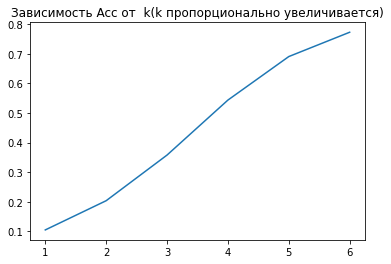

In [70]:
import seaborn as sns
sns.lineplot(x=[i for i in range(1,7)], y=[i['accuracy'] for i in tests_similar],).set_title('Зависимость Acc от  k(k пропорционально увеличивается)')


Text(0.5, 1.0, 'Зависимость числа параметров от  k(k пропорционально увеличивается)')

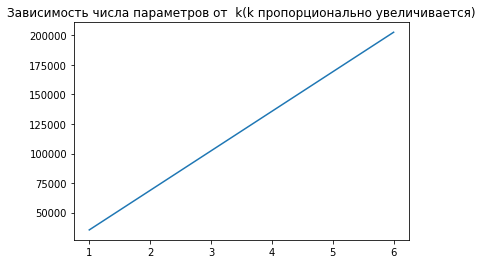

In [71]:
sns.lineplot(x=[i for i in range(1,7)], y=[i['num_parameters'] for i in tests_similar],).set_title('Зависимость числа параметров от  k(k пропорционально увеличивается)')



In [36]:
import pandas as pd
import numpy as np
dfs=[]
for i in range(1,4):
    for j in range(1,4):
        for k in range(1,4):
            res=check(prune_all,[i*4]*3+[j*8]*3+[k*16]*3)
            df=pd.DataFrame(index=None,data={'i':[i],'j':[j],'k':[k],'acc':[res['accuracy']],'num_parameters':[res['num_parameters']]})
            dfs.append(df)

In [72]:
# Варьируем число кластеров для каждого layer
df=pd.concat(dfs)

In [73]:
df['i']*=4
df['j']*=8
df['k']*=16


In [74]:
# Корреляция между параметрами и метриками
df.corr()[['acc','num_parameters']]

,acc,num_parameters
i,0.319270,0.066326
j,0.314795,0.242432
k,0.868530,0.967899
acc,1.000000,0.938141
num_parameters,0.938141,1.000000


In [75]:
# Корреляция Спирмана между параметрами и метриками

df.corr(method='spearman')[['acc','num_parameters']]

,acc,num_parameters
i,0.361076,0.104828
j,0.308662,0.314485
k,0.856099,0.943456
acc,1.000000,0.942613
num_parameters,0.942613,1.000000


Вывод: Метод позволяет удалить малозначащие веса с небольшими потерями в качестве, что позволит ускорить выполнение модели за счет уменьшения числа параметров.  
Больше всего на качество модели и число параметров влияет K для последнего слоя. Влияние на число параметров выше.

 Идеи для улучшения:   
 1) кластеризовать не все свертки, а только наименее значащие  
 2) Попробовать внутри слоя тоже давать разные k.  
 3) Очевидно, прореживать каналы итеративно с дообуением с маленьким шагом градиентного спуска.  
 4) +к шагу 3, можно постепенно с ростом номера иттерации начать подмешивать в тренировочные данные еще и (x;prob), где prob это выходы исходной модели(Комбинируем дистиляцию знаний и прунинг)   